asdasd




In [51]:
import itertools
import pickle
import pandas as pd
from deap import creator
import numpy as np
import matplotlib.pyplot as plt

In [21]:


def parse_file(path):
    data = []
    with open(path, 'r') as f:
        lines = f.readlines()
        opt = int(lines[0].replace('optimum=', ''))
        time = float(lines[1].split(',')[0].replace('execution_time=', ''))
        trace = []
        for idx,f in enumerate(lines[3:]):
            parts = f.split(',')
            fitness = int(float(parts[0].replace('fitness=', '')))
            iteration = int(float(parts[1].replace('iteration=', '')))
            gap = float(parts[2].replace('gap=', ''))
            delta = int(float(parts[3].replace('delta=', '')))
            timestamp = float(parts[4].replace('timestamp=', ''))
            data.append((idx, opt, time, fitness, iteration, gap, delta, timestamp))
    return data

In [94]:
def load_full_experiment(path, algs, ns, runs, ls):
    data = []
    for alg, n in list(itertools.product(algs, ns)):
        for i in runs:
            filename = path + "result_{}_{}_{}_{}.txt".format(alg, n, i, ls)
            dat = parse_file(filename)
            data = data + [(alg,n,i)+d for d in dat]

    return data


def load_ga_aco_dnala(path, ls):
    algs = ["ga", "aco", "dnala"]
    ns = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200]
    basepath = path
    runs = range(0, 5)
    data = load_full_experiment(basepath, algs, ns, runs, ls)

    df = pd.DataFrame(data=data, columns=['alg','n','i','idx','optimum', 'time', 'fitness', 'iteration', 'gap', 'delta', 'timestamp'])
    df = df.set_index(['alg','n','i','idx'])

    df = df.groupby(by=['alg','n','i']).apply(lambda x: x.sort_values(['idx'], ascending=True)).groupby(by=['alg','n','i']).tail(1).groupby(by=['alg','n']).median()

    df['time'] = np.minimum(np.floor(df['time']),300)
    df = df.drop(columns=['timestamp','delta'])
    return df

print('NO-LocalSearch')
without_ls = load_ga_aco_dnala('./output/results_nols/', False)

#print('WITH-LocalSearch 100BF')
#load_ga_aco_dnala('./output/results_100-ls/', True)

print('WITH-LocalSearch 50FF')
with_ls = load_ga_aco_dnala('./output/results_50-ff-ls/', True)

with_ls.drop(columns='optimum',inplace=True)
main_table = pd.concat([without_ls, with_ls], axis=1)

print(main_table.to_latex())

#main_table.drop(columns=['optimum'], inplace=True)
#print(main_table)


NO-LocalSearch
WITH-LocalSearch 50FF
\begin{tabular}{llrrrrrrrrr}
\toprule
   &     &  optimum &   time &  fitness &  iteration &         gap &   time &  fitness &  iteration &        gap \\
alg & n &          &        &          &            &             &        &          &            &            \\
\midrule
aco & 10  &     1994 &    0.0 &     1994 &          0 &    0.000000 &    0.0 &     1994 &          0 &   0.000000 \\
   & 20  &    11758 &    0.0 &    11758 &          0 &    0.000000 &    0.0 &    11758 &          0 &   0.000000 \\
   & 30  &    19032 &    0.0 &    19032 &          2 &    0.000000 &    0.0 &    19032 &          0 &   0.000000 \\
   & 40  &    20892 &   10.0 &    20892 &         88 &    0.000000 &    0.0 &    20892 &          0 &   0.000000 \\
   & 50  &    34198 &  300.0 &    34320 &        280 &    0.356746 &    1.0 &    34198 &          0 &   0.000000 \\
   & 60  &    42382 &  300.0 &    44310 &        317 &    4.549101 &    2.0 &    42382 &          0 &   

optimum  time  fitness  iteration         gap
population_size n                                                 
50              50     34198  12.0    34198        498    0.000000
                100    83495  50.0   103653        649   24.142763
                200   130178  50.0   412332        164  216.744765
100             50     34198  18.0    34198        359    0.000000
                100    83495  50.0   105781        398   26.691419
                200   130178  50.0   364338        130  179.876784
300             50     34198  13.0    34198         93    0.000000
                100    83495  50.0    95859        289   14.808072
                200   130178  50.0   276058        140  112.061946

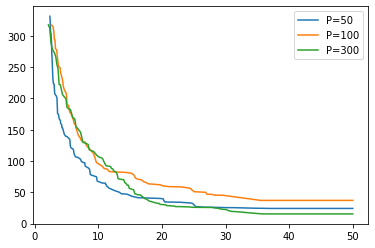

In [87]:
def load_ga_population_comparison_full_experiment(path, ns, runs, population_sizes):
    data = []
    for population_size, n in list(itertools.product(population_sizes, ns)):
        for i in runs:
            filename = path + "result_{}_ga_{}_{}.txt".format(n,population_size, i)
            dat = parse_file(filename)
            data = data + [(n,i,population_size)+d for d in dat]

    return data


def load_ga_population_comparison(path):
    ns = [50,100,200]
    population_sizes = [50,100,300]
    basepath = path
    runs = range(0, 5)
    data = load_ga_population_comparison_full_experiment(basepath, ns, runs, population_sizes)

    raw = pd.DataFrame(data=data, columns=['n','i','population_size','idx','optimum', 'time', 'fitness', 'iteration', 'gap', 'delta', 'timestamp'])
    df = raw.set_index(['n','i','population_size','idx'])

    df = df.groupby(by=['population_size','n','i']).apply(lambda x: x.sort_values(['idx'], ascending=True)).groupby(by=['population_size','n','i']).tail(1).groupby(by=['population_size','n']).median()

    df['time'] = np.minimum(np.floor(df['time']),50)
    df = df.drop(columns=['timestamp','delta'])

    pg = raw.drop(columns=['iteration', 'idx','delta','fitness','time'])

    # df2 = raw.groupby(by=['population_size','n','i'])
    instance_size = 100
    instance = 3

    pop_50 = pg[(pg.i == instance) & (pg.n == instance_size) & (pg.population_size == 50)][['gap','timestamp']]
    pop_100 = pg[(pg.i == instance) & (pg.n == instance_size) & (pg.population_size == 100)][['gap','timestamp']]
    pop_300 = pg[(pg.i == instance) & (pg.n == instance_size) & (pg.population_size == 300)][['gap','timestamp']]

    pop_50 = pd.concat([pop_50, pd.DataFrame(data=[(pop_50['gap'].min(), 50)], columns=['gap','timestamp'])])
    pop_100 = pd.concat([pop_100, pd.DataFrame(data=[(pop_100['gap'].min(), 50)], columns=['gap','timestamp'])])
    pop_300 = pd.concat([pop_300, pd.DataFrame(data=[(pop_300['gap'].min(), 50)], columns=['gap','timestamp'])])

    fig = plt.figure()
    fig.add_subplot(1,1,1)

    plt.plot(pop_50['timestamp'],pop_50['gap'], label='P=50')
    plt.plot(pop_100['timestamp'],pop_100['gap'], label='P=100')
    plt.plot(pop_300['timestamp'],pop_300['gap'], label='P=300')
    plt.legend(loc='best')
    # print(pop_50)
    # print(pop_100)
    # print(pop_300)

    return df

load_ga_population_comparison('./output/ga_only_population_sizes/')